In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm

**Comments not up to date yet**

# *Simple univariate example of a normalizing flow*

*Problem description*

Consider the target variable X to be defined as : $$X\sim \mathcal{N}(\mu_X ; \sigma_X)$$ with parameters $$ \mu_X \text{ and } \sigma_X \text{fixed but unknown.} $$ We will use a transformation such that $$ T(u)  = A.u + b $$


In [29]:
#The true values unkown to the simulator
mu_x = 3
sigma_x = 0.5
N = 1000
N = 3
N_test = 10*N
def gen_observations(number_of_observations:int):
    """Generates a tensor of observations, i.e. x drawn from a normal distribution having mu=mu_x and sigma=sigma_x

    Args:
        number_of_observations (int): Number of obs to generates

    Returns:
        torch.tensor : Tensor of observations
    """

    # Number of sample 
  
    #Generating observations from the true distribution
    X = torch.randn((number_of_observations , ))
    return X


X=gen_observations(N)
X_test = gen_observations(N_test)

In [31]:
class T(nn.Module):
    """Transformation T(u) = A.u + b

    Args:
        None
        
    """
    
    def __init__(self, A, b, prior):
        """Init with a single linear layer, with bias
        """
        super(T, self).__init__()
        if A <0:
            raise ValueError(" 'A' has to be non negative. ")
        self.b = nn.Parameter(torch.Tensor([b]))
        self.alpha = nn.Parameter(torch.Tensor([np.log(A)]))
        self.prior = prior
    
    def forward(self,x:torch.tensor):
        """Compute the linear transformation

        Args:
            u (torch.tensor)

        Returns:
            A*x + b
        """
        A = torch.exp(self.alpha)
        z = A * x + self.b
        return z
    
    def L(self, x): #TODO Utiliser formule + générale (avec changement de var) pour être + flexible (même sans savoir qu'on veut une Gausienne) [calculer J dans forward w/ autograd]
        """Compute the loss as -log(p_est(x))
        """
        z = self.forward(x)
        J =torch.autograd.functional.jacobian(self.forward, x)
        log_det_J = torch.log(torch.abs(torch.det(J))).mean()
        res = self.prior.log_prob(z).sum() + log_det_J
        #TODO Mettre mean() ici
        return - res.mean()

In [32]:
n_iter = 10000 #Number of iteration
transformation = T( 1, 1, torch.distributions.Normal(loc=0,scale=1)) #Instanciation #TODO Voir si on instancie loin de la vraie moyenne, temps de CV augmente etc.
learning_rate = 1e-3
optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
#optimizer = torch.optim.Adam(transformation.parameters(), learning_rate)#TODO Utiliser Adam (en vrai SGD marche bien pck problème simple, convexe mais Adam très utlisé )

In [33]:
# Keeping records of these values for later visualisations
losses_train = []
estimated_A = []
estimated_b = []

stable_loss = False
epsilon = 1e-3 # IF distance(Loss(test_time_k) ; (test_time_k+1)) < epsilon we stop the training, the convergence is "achieved"
with torch.no_grad():
    previous_loss_test = transformation.L(X_test).mean().detach().item()
    
for i in range(n_iter):
    
    #Computing train loss
    loss_train = transformation.L(X).mean()
    losses_train.append(loss_train.detach().item())
    
    #Optimizaton steps
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    #Keeping records of the estimated parameters
    A_hat, b_hat = torch.exp(transformation.alpha).detach().item(), transformation.b.detach().item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)
    
    #Is convergence achieved?
    if i%10 ==0: #We check the convergence every ten iterations
        with torch.no_grad():
            loss_test = transformation.L(X_test).mean().detach().item() #Loss on the test batch
        stable_loss = abs(loss_test - previous_loss_test) < epsilon
        if stable_loss:
            print(f"Early stop at iteration {i}")
            break
        previous_loss_test = loss_test

Early stop at iteration 530


In [34]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1] 

sample_mean = torch.mean(X)
sample_sigma = torch.std(X, unbiased=False)

print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final training loss = ", losses_train[-1])

 Sample mean = 0.34222283959388733 and b_hat =  -0.011579280719161034
 Sample std = 0.14892986416816711 and A_hat =  0.727196216583252
 Final training loss =  3.8144569396972656


As expected, the estimated expectation (resp. standard deviation) converges to the sample expectation (resp. standard deviation)

# Visualisation

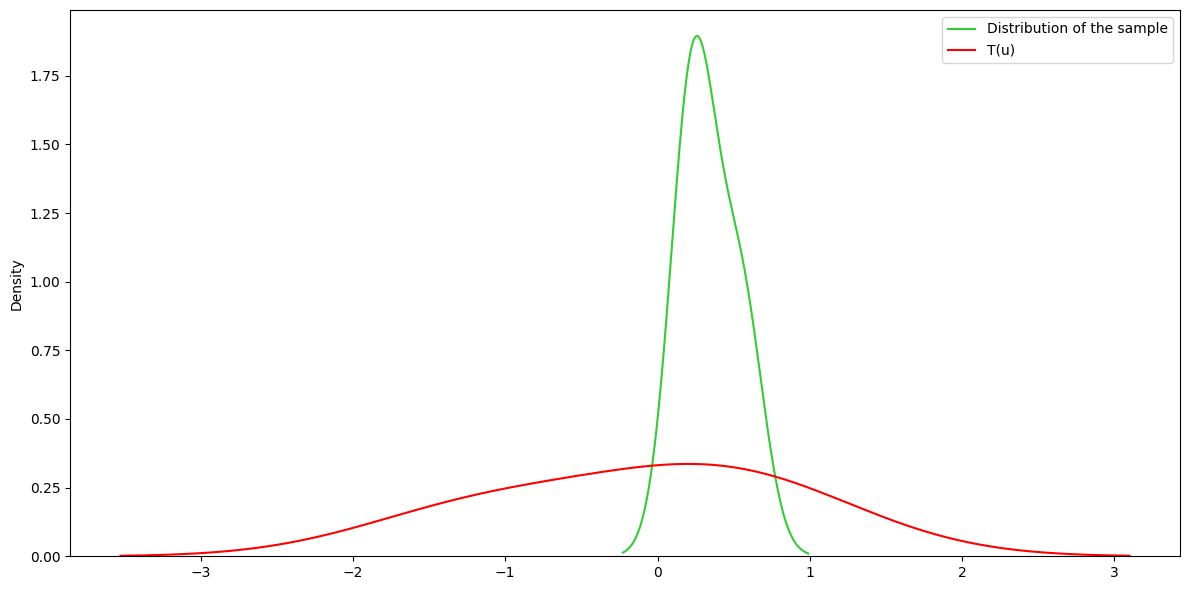

In [35]:
U = torch.distributions.Normal(0, 1).sample((N,1)) # True std Gaussian
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= transformation.forward(U).detach().squeeze(), ax = ax, color='red', label='T(u)')
ax.legend()
plt.tight_layout()
plt.show()

NameError: name 'losses' is not defined

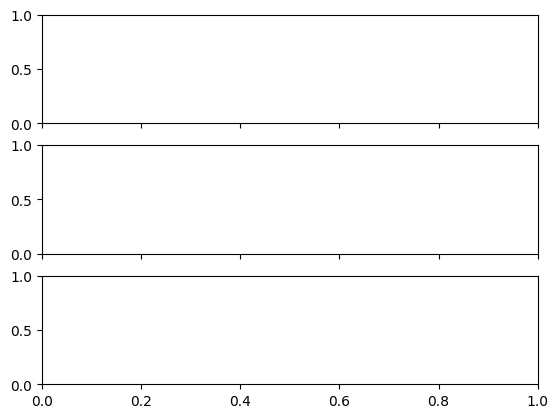

In [36]:
fig, axs = plt.subplots(3, sharex = True)
axs[0].plot(losses)
axs[0].set_title("Loss VS nb_iter")
axs[1].plot(estimated_b)
axs[1].hlines(y=sample_mean,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample mean", linestyles='dashed')
axs[1].legend()
axs[1].set_title("Estimated bias VS nb_iter")
axs[2].plot(estimated_A)
axs[2].hlines(y=sample_sigma,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample std", linestyles='dashed')
axs[2].legend()
axs[2].set_title("Estimated weight VS nb_iter")
fig.tight_layout()

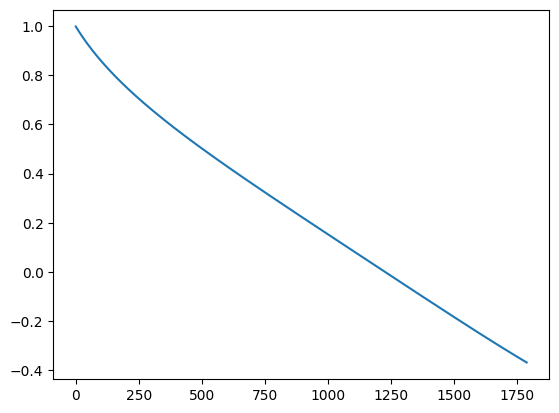

In [ ]:
plt.plot(estimated_b)

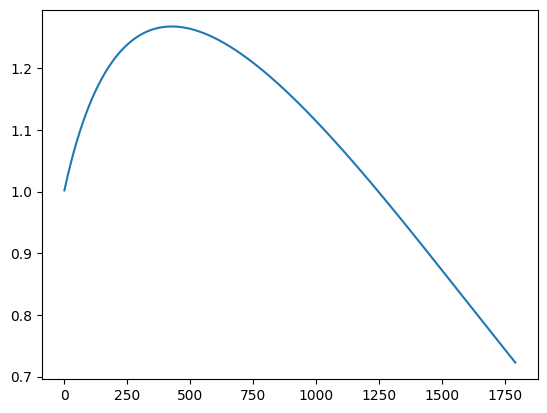

In [ ]:
plt.plot(estimated_A)

### Let us compute the loss on a training set

In [ ]:
with torch.no_grad():
    loss_t = transformation.L(X_test).mean()
print(loss_t)
losses[-1] # Pas grande différence avec la final loss sur le train

tensor(1.7247)


0.739168643951416

## Effect of sample size

In [ ]:
estimated_A = []
estimated_b = []
sample_sizes = []
n_iter = 200
last_losses = []
sample_means = []
sample_sigmas = []
for sample_size in tqdm(range(10,1000,20)): #TODO Pour chaque sample size, generer 10 echantillons et prendre la loss moyenne pour tuer l'aléatoire de gen (ex ech de tailel 10 si toutes les données sont concentrées...)
    sample_sizes.append(sample_size)
    X = gen_observations(sample_size)
    transformation = T()
    optimizer = torch.optim.SGD(transformation.parameters(),learning_rate)
    #training 
    for i in range(n_iter):
        #Loss
        loss = transformation.L(X).mean()
        #optim
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    last_losses.append(loss.detach().numpy().item())
    A_hat, b_hat = torch.exp(transformation.alpha).item(), transformation.b.item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)
    sample_mean = torch.mean(X)
    sample_sigma = torch.std(X, unbiased=False)
    sample_means.append(sample_mean)
    sample_sigmas.append(sample_sigma)
    

  0%|          | 0/50 [00:00<?, ?it/s]

TypeError: __init__() missing 2 required positional arguments: 'A' and 'b'

In [ ]:
print(last_losses)
print(np.mean(last_losses))

[0.41243672370910645, 0.7193450927734375, 0.6686338782310486, 0.7402182221412659, 0.7947520613670349, 0.6876314282417297, 0.7366220355033875, 0.7464224696159363, 0.8137525916099548, 0.6880249977111816, 0.8150820732116699, 0.6825340390205383, 0.8049429655075073, 0.638878345489502, 0.7248972654342651, 0.7406392097473145, 0.7417750954627991, 0.6855349540710449, 0.709421694278717, 0.7600938081741333, 0.6667622923851013, 0.7604995965957642, 0.7376801371574402, 0.7393658757209778, 0.6535958051681519, 0.7074360251426697, 0.702779233455658, 0.8117752075195312, 0.7337253093719482, 0.7073891758918762, 0.7311956882476807, 0.7226260304450989, 0.7405994534492493, 0.7262683510780334, 0.7339304089546204, 0.7191258668899536, 0.7450248003005981, 0.7145274877548218, 0.7614303827285767, 0.7759031057357788, 0.7176005244255066, 0.7323552966117859, 0.6792657375335693, 0.7106080055236816, 0.7334171533584595, 0.6913715600967407, 0.6985196471214294, 0.7052993178367615, 0.7070137858390808, 0.739168643951416]
0.

In [ ]:
dist_b = abs(np.subtract(sample_means, estimated_b))
dist_A = abs(np.subtract(sample_sigmas, estimated_A))

Text(0.5, 1.0, "Distance between weight A and sample std'")

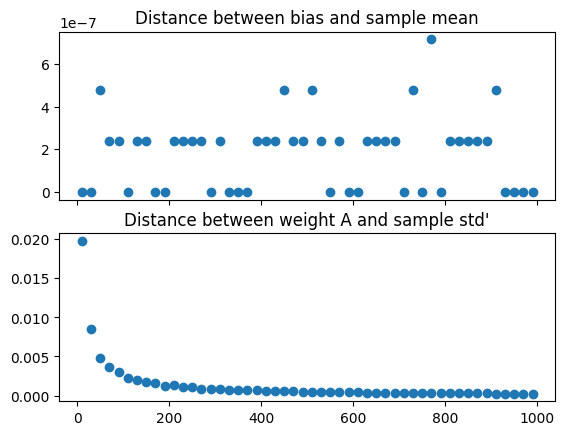

In [ ]:
fig, axs = plt.subplots(2, sharex = True)
axs[0].scatter(sample_sizes, dist_b)
#axs[0].set_ylim(-0.5,10)
axs[0].set_title("Distance between bias and sample mean") #Pas très lisible ...
axs[1].scatter(sample_sizes, dist_A)
#axs[1].set_ylim(-0.5,10)
axs[1].set_title("Distance between weight A and sample std'")


## What if if X is not gaussian (here chi2)

In [ ]:
X_chi = np.random.chisquare(2, N)
X_chi = torch.from_numpy(X_chi)
X_chi = X_chi.reshape(X_chi.size()[0] , 1)
X_chi = X_chi.type(torch.float32)

In [ ]:
transformation2 = T() #Instanciation
optimizer = torch.optim.SGD(transformation2.parameters(), learning_rate)

In [ ]:
losses = []
estimated_A = []
estimated_b = []
for i in range(n_iter):
    #Computing & saving the loss
    loss = transformation2.L(X_chi).mean()
    losses.append(loss.detach().numpy().item())
    #optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Saving parameters for later vizualisation
    A_hat, b_hat = torch.exp(transformation2.alpha).item(), transformation2.b.item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)

In [ ]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1]
sample_mean = torch.mean(X_chi)
sample_sigma = torch.std(X_chi, unbiased=True)
print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final loss = ", losses[-1])

 Sample mean = 1.940566897392273 and b_hat =  1.8973475694656372
 Sample std = 1.9678539037704468 and A_hat =  1.967506766319275
 Final loss =  2.0956361293792725


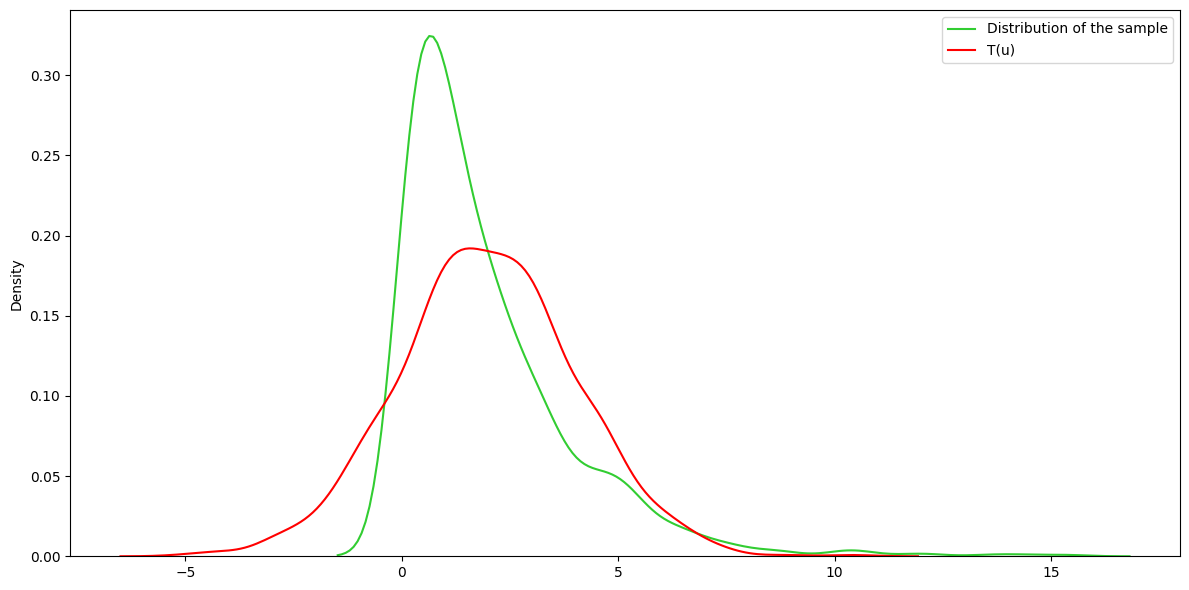

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X_chi.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= transformation2.forward(U).detach().squeeze(), ax = ax, color='red', label='T(u)')
ax.legend()
plt.tight_layout()
plt.show()#TODO Overlayed avec un histo ?

In [ ]:
#TODO Voir si on peut ajouter quelques couches simples en se basant sur la description du papier 